# Data loading

In [ ]:
import os
import time
import subprocess
import numpy as np
import pandas as pd

In [ ]:
data_path = '/home/iit/CDGCN/data/docking'
output_path = '/home/iit/CDGCN/outputs/docking'

In [ ]:
pdb_files = [each for each in os.listdir(data_path) if each.endswith('.pdb')]
pdb_files

In [248]:
modelname = 'Grechishnikova'
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
all_smiles_df_beams[0][0][0]

,smiles,MW,logP,QED,HD,HA,RB,TPSA,SAS
0,O=CNC(Cc1cnn(-c2cccc(NC(=O)c3cc(C(F)(F)F)c(F)c...,504.142068,3.90160,0.302273,3,5,9,113.32,3.277372
1,CS(=O)(=O)N(c1cccc(C(=O)O)c1)c1cccc(C(F)(F)F)c1,359.043914,3.50130,0.906635,1,3,4,74.68,2.308986
2,CCCC1CC(c2ccc(-c3ccccc3CN(C)C(N)=O)cc2)NC1=O,365.210327,3.84140,0.815920,2,2,6,75.43,3.245543
3,CCCNC(=O)c1cc(-c2ccc(CN3CC=C4CCCC(F)(F)C4(C)C3...,468.233683,4.56470,0.608415,2,4,6,88.32,3.615708
4,CC(C)Oc1ccc(CNCC2COc3ccccc3C(=O)N2)cc1Cl,374.139720,3.40780,0.813092,2,4,6,59.59,2.871279
5,O=C1Nc2cc(-c3ccc4c(CN5CCCC5)n[nH]c4c3)ccc2C1C1...,416.221226,4.28800,0.665751,2,4,4,70.25,3.305602
6,CCC(C)C(NC(=O)NC1=CS(=O)(=O)N2CCCC2C1)c1ccc(C(...,498.160677,1.80170,0.523359,3,6,7,141.75,4.151892
7,Cc1ccc(NC(=O)C2CN3CCC2CC3)cc1-c1cccc(C=CCO)c1,376.215078,3.94782,0.830820,2,3,5,52.57,3.647041
8,CC=C1COCC2C1N(Cc1ccccc1)CCN(S(=O)(=O)c1ccccc1-...,547.214092,3.69540,0.277514,2,6,6,99.18,3.889670


# Molecular docking

This is the main protocol of Jupyter Dock.

## Content of this notebook

1. Feching system and cleanup
2. Protein and ligand sanitization
3. System Visualization 
4. Docking with AutoDock Vina
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - PDBQT results file conversion to SDF
    - 3D visualization of docking results
    - 2D interaction table and map
5. Docking with LeDock
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - DOK results file conversion to SDF
    - 3D visualization of docking results
    - 2D interaction table and map

In [ ]:
from pymol import cmd
import py3Dmol

from vina import Vina

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork


import sys, os
sys.path.insert(1, 'utilities/')
from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf


import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

It's a good idea to run the test protocols before attempting custom projects. Later, the user can specify the location of his/her project and save all of the files separately.

In [ ]:
os.chdir(data_path)

## 1. Feching system and cleanup

Implementing Pymol is a simple way to download PDB structures. The user can launch this or any other Jupyter Dock's protocol by providing his or her own files.

In [ ]:
for pdb_id in pdb_files:
    pdb_id = pdb_id[:-4]
    os.chdir(data_path)
    cmd.fetch(code=pdb_id,type='pdb')
    cmd.select(name='Prot',selection='polymer.protein')
    cmd.select(name='Lig',selection='organic')
    os.chdir(output_path)
    cmd.save(filename=pdb_id+'_clean.pdb',format='pdb',selection='Prot')
    cmd.save(filename=pdb_id+'_lig.mol2',format='mol2',selection='Lig')
    cmd.delete('all')

In [ ]:
os.chdir(output_path)

## 2. Protein and ligand sanitization

### 2.1. Protein Sanitization

#### Method 1: LePro

The Lephar molecular docking suite includes a very powerful tool for automatically preparing proteins for molecular docking. As a result, for these protocols, it will be the preferred tool for protein preparation. The protein prepared by LePro can be used in AutoDock VIna and LeDock.

In [ ]:
!chmod +x /home/iit/Jupyter_Dock/bin/lepro_linux_x86
!/home/iit/Jupyter_Dock/bin/lepro_linux_x86 # Launch this cell to see parameters

In [ ]:
for pdb_id in pdb_files:
    pdb_id = pdb_id[:-4]
    os.system('chmod +x /home/iit/Jupyter_Dock/bin/lepro_linux_x86')
    os.system('/home/iit/Jupyter_Dock/bin/lepro_linux_x86 {}_clean.pdb'.format(pdb_id))

    os.rename('pro.pdb','{}_clean_H.pdb'.format(pdb_id)) # Output from lepro is pro.pdb, this line will change the name to '1AZ8_clean_H.pdb'

In [ ]:
for pdb_id in pdb_files:
    pdb_id = pdb_id[:-4]
    fix_protein(filename=f'{pdb_id}_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output=f'{pdb_id}_clean_H.pdb')

### 2.2. Ligand sanitization

Due to the variability of ligands and formats, ligand sanitization and preparation can be one of the most difficult tasks to complete. Setting protonation states for a ligand, for example, can be difficult. It is highly recommended that the user knows and understands the proper states for his/her ligand(s) when using Jupyter Dock or any other molecular docking approach.

In this example, after splitting the ligand and protein after fetching with pymol, the ligand has sanitization problems **(sanitize=False in Chem.MolFromMol2File)**

In [243]:
beam = 0
run = 3
prot_id = 6
pdb_id = '1cqp'
m = []
for i, smiles in enumerate(all_smiles_df_beams[beam][run][prot_id]['smiles']):
    os.system(f"obabel -:\"{smiles}\" --gen3D -O {pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}.mol2")
    m.append(Chem.MolFromMol2File(f'{pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}.mol2',sanitize=False))
    mol = [m for m in pybel.readfile(filename=f'{pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}.mol2',format='mol2')][0]
    mol.addh()
    out = pybel.Outputfile(filename=f'{pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_H.mol2',format='mol2',overwrite=True)
    out.write(mol)
    out.close()

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted


In [244]:
len(m)

10

RDKit ERROR: [05:23:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 17 18 19 20
[05:23:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 17 18 19 20

RDKit ERROR: 


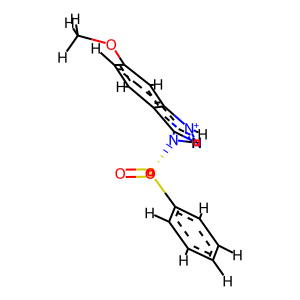

In [245]:
Draw.MolToImage(m[0])

>**Hint:** One solution for simple sanitization problems is to use OpenBAbel to convert the molecule and add the necessary hydrogens for molecular docking (Pybel). The definitions for carrying out molecules in OpenBabel differ from those in RDKIt. As a result, OpenBabel is capable of handling the conversion.

The end result of ligand sanitization is a new molecule that RDKit can display without having to use the sanitization parameter. Furthermore, the output structure for this example corresponds exactly to the one reported in the PDB database (PDB 1AZ8)

In [ ]:
m=Chem.MolFromMol2File(f'{pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_H.mol2')
m

## 3. Docking with AutoDock Vina

AutoDock Vina (Vina) is one of the docking engines in the AutoDock Suite, together with AutoDock4 (AD4), AutoDockGPU, AutoDockFR, and AutoDock-CrankPep, and arguably among the most widely used and successful docking engines. The reasons for this success are mostly due to its ease of use and its speed (up to 100x faster than AD4), when compared to the other docking engines in the suite and elsewhere, as well as being open source.

### 3.1. Protein preparation

After sanitization, the protein docking preparation includes converting it to the PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand. 

>**Hint:** Despite the fact that the PDBQT format includes changes (Q) and atom types (T) for molecular docking. The charges are not required for Autodock Vina, which computes electrostatic interactions using its own force field. Although, when using AutoDock instead of AutoDock Vina, the Q term is required. More information can be found here:https://autodock-vina.readthedocs.io/en/latest/introduction.html

#### Method 1: AutoDock Tools prepare_receptor

The AutoDock Tools are the best way to prepare the receptor for AutoDock Vina. Nonetheless, AutoDock Tools is a comprehensive suite of programs and scripts that are difficult to manage. Jupyter Dock execute the **_prepare receptor_** and **_prepare_ligand_** functions on their own. As a result, obtaining proper PDBQT files for AutoDock Vina has never been easier.

>**Warning:** There is currently only one method for preparing a PDBQT file for a receptor. It is expected that new methods apart from AutoDock Tools executables will be included in the near future into Jupyter Dock.

In [ ]:
!chmod +x /home/iit/Jupyter_Dock/bin/prepare_receptor
!/home/iit/Jupyter_Dock/bin/prepare_receptor #Lauch this cell to see parameters

In [ ]:
for pdb_id in pdb_files:
    pdb_id = pdb_id[:-4]
    os.system('chmod +x /home/iit/Jupyter_Dock/bin/prepare_receptor')
    os.system('/home/iit/Jupyter_Dock/bin/prepare_receptor -v -r {}_clean_H.pdb -o {}_clean_H.pdbqt'.format(pdb_id, pdb_id))

### 3.2. Ligand preparation

As previously discussed, one of the major challenges for proper docking experimentation is ligand preparation.

>**Hint:** The hydroges in this example were set during the ligand sanitization step (section 2.2). As a result, the ligand will be prepared as is. Furthermore, before running the docking, it is highly recommended to inspect the ligand(s) after preparation to ensure proper structure and molecule features.

#### Method 1: AutoDock Tools prepare_ligand

In [ ]:
!chmod +x /home/iit/Jupyter_Dock/bin/prepare_ligand
!/home/iit/Jupyter_Dock/bin/prepare_ligand #Launch this cell to see parameters

In [246]:
beam = 0
run = 3
prot_id = 6
pdb_id = '1cqp'
for i, smiles in enumerate(all_smiles_df_beams[beam][run][prot_id]['smiles']):
    os.system('chmod +x /home/iit/Jupyter_Dock/bin/prepare_ligand')
    os.system(f'/home/iit/Jupyter_Dock/bin/prepare_ligand -v -l {pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_H.mol2 -o {pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_H.pdbqt')

set verbose to  True
set ligand_filename to  1cqp_7_gen_mol1_Grechishnikova_H.mol2
set outputfilename to  1cqp_7_gen_mol1_Grechishnikova_H.pdbqt
read  1cqp_7_gen_mol1_Grechishnikova_H.mol2
setting up LPO with mode= automatic and outputfilename=  1cqp_7_gen_mol1_Grechishnikova_H.pdbqt
and check_for_fragments= False
and bonds_to_inactivate= 
returning  0
No change in atomic coordinates
set verbose to  True
set ligand_filename to  1cqp_7_gen_mol2_Grechishnikova_H.mol2
set outputfilename to  1cqp_7_gen_mol2_Grechishnikova_H.pdbqt
read  1cqp_7_gen_mol2_Grechishnikova_H.mol2
setting up LPO with mode= automatic and outputfilename=  1cqp_7_gen_mol2_Grechishnikova_H.pdbqt
and check_for_fragments= False
and bonds_to_inactivate= 
returning  0
No change in atomic coordinates
set verbose to  True
set ligand_filename to  1cqp_7_gen_mol3_Grechishnikova_H.mol2
set outputfilename to  1cqp_7_gen_mol3_Grechishnikova_H.pdbqt
read  1cqp_7_gen_mol3_Grechishnikova_H.mol2
setting up LPO with mode= automatic a

#### Method 2: Meeko

This is the preferred method out of AutoDock Tools. Apart from ligand preparation, Meeko provides tools for other docking aspects that the AutoDock Tools software suite does not cover. Hydrated docking and macrocycles are two examples. More about Meeko https://pypi.org/project/meeko/

>**Info**  To run Meeko change the next cell type from "Markdown" to "Code".

```
mol = obutils.load_molecule_from_file('1AZ8_lig_H.mol2')

preparator = MoleculePreparation(merge_hydrogens=True,hydrate=False)
preparator.prepare(mol)

preparator.write_pdbqt_file('1AZ8_lig_H.pdbqt')
```

#### Method 3: Pybel

OpenBabel (pybel) can handle a variety of file formats and conversions between them. As a result, any chemical format file can be converted directly to PDBQT. Nonetheless, pybel may encounter issues if the source file format contains errors. 

>**Info**  To run Pybel change the next cell type from "Markdown" to "Code".

```
ligand = [m for m in pybel.readfile(filename='1AZ8_lig_H.mol2',format='mol2')][0]
out=pybel.Outputfile(filename='1AZ8_lig_H.pdbqt',format='pdbqt',overwrite=True)
out.write(ligand)
out.close()
```

### 3.3. Box definition

This is possibly the most important feature of Jupyter Dock. Making a docking box without the use of a visualizer or any other additional tools. As a result, AutoDock Vina (and LeDock) can now be run entirely in a Jupyter notebook.

Mengwu Xiao and his clever Pymol plug-in ["GetBox"](https://github.com/MengwuXiao/GetBox-PyMOL-Plugin) inspired the box definition in Jupyter Dock. 

Jupyter Dock makes use of Mengwu Xiao Pymol implementation, but this time through the Pymol API.

>**Warning:** The function **_get_box()_** is built into the Pymol API. As a result, in order to compute the docking box, the docking system files must be initialized using Pymol.

>**Hint:** The integration of **_get_box()_** as Pymol integration allows the definition of amazing boxes based on Pymol's powerful selection tools. A ligand, a residue, a set of residues, atom(s), pseudoatom(s), and any custom selection valid within the [Pymol selection algebra](https://pymolwiki.org/index.php/Selection_Algebra) can be used to set the box.  

**_get_box( params )_**

params:

   - **selection**: _str , pymol_selection_; The selection for docking box, can be atom, resn, resid, or any other pymol selection
   
   - **extending**: _float_; value to extend the boundaries of the selection
   
   - **software**: _str , 'vina','ledock', 'both'_ ; Depending on selected software the funtion will provide the box coordinates in vina, ledock, or both formats

### 3.4. Docking

#### Method 1: vina

AutoDock Vina 1.2.0, which was recently released, now allows AutoDock Vina to be executed using Python Bindings. Jupyter Dock takes advantage of this feature to make the docking protocol run entirely within a Jupyter notebook.

#### Metod 2: Smina

Despite the presence of Python bindings in AutoDock Vina 1.2.0, other tools that incorporate AutoDock Vina allow for cool features such as custom score functions (smina), fast execution (qvina), and the use of wider boxes (qvina-w). Jupyter Dock can run such binaries in a notebook, giving users more options.

>**Info:** The following cell contains an example of using smina to run the current docking example. However, the executable files for qvina and qvina-w are available in the Jupyter Dock repo's bin directory. As a result, the user can use such a tool by adding the necessary cells or replacing the current docking engine.

>**Info** To run smina change the cell type from "Markdown" to "Code".

In [247]:
beam = 0
run = 3
prot_id = 6
pdb_id = '1cqp'
for i, smiles in enumerate(all_smiles_df_beams[beam][run][prot_id]['smiles']):
    cmd.load(filename='{}_clean_H.pdb'.format(pdb_id),format='pdb',object='prot')
    cmd.load(filename=f'{pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_H.mol2',format='mol2',object='lig')

    center, size= getbox(selection='lig',extending=5.0,software='vina')

    cmd.delete('all')
    
    print('PDB:', pdb_id)
    os.system('chmod +x /home/iit/Jupyter_Dock/bin/smina')
    os.system(f'/home/iit/Jupyter_Dock/bin/smina -r {pdb_id}_clean_H.pdbqt -l {pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_H.pdbqt -o {pdb_id}_{prot_id+1}_gen_mol{i+1}_{modelname}_smina_out.pdbqt --center_x 31.859 --center_y 13.34 --center_z 17.065 --size_x 24.569 --size_y 18.12 --size_z 17.37 --exhaustiveness 8 --num_modes 5 #Lauch this cell to see parameters')
    print()

PDB: 1cqp
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -1343120016

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.3       0.000      0.000    
2       -6.0       2.983      5.110    
3       -5.8       3.864      7.828    
4       -5.7       2.633      4.188    
5       -5.6       1.847      2.810    
Refine time 6.962
Loop time 7.606

PDB: 1cqp
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069 